# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure. Each machine failed immediately after the last recorded timestamp in the remote monitoring timeseries data.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,4
unique,4
top,304
freq,1


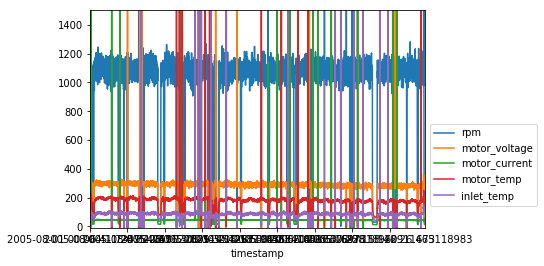

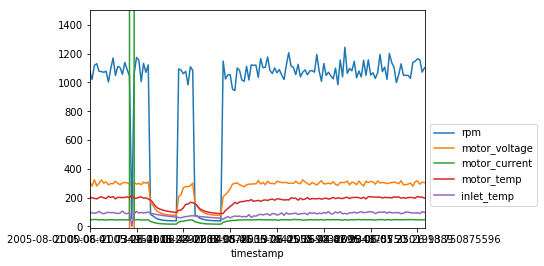

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp").describe()

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500)).legend(bbox_to_anchor=(1.0, 0.5))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500)).legend(bbox_to_anchor=(1.0, 0.5))

display(rms.describe())
display(alarms.describe())

From the plots above, we can see the data is indeed very noisy. To get a cleaner view, we can filter out the outliers by setting up a good percentile boundary to the dataset. Multiple methods are capable of do this. Here I implemented two functions. One result is shown.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,89879.000000,89879.000000,89879.000000,89879.000000,89879.000000
mean,945.402452,246.522636,37.066815,154.910482,77.689919
std,347.858561,76.642683,11.272861,46.728482,18.557995
min,-14.155331,-27.989543,-6.394155,29.233108,23.248012
25%,1019.206491,231.701333,32.472900,118.454022,65.162500
50%,1066.347072,266.710408,39.446872,156.452066,77.991573
75%,1105.826549,298.905064,45.963415,197.103594,90.616818
max,1219.675067,333.593761,50.750685,288.358685,202.220256


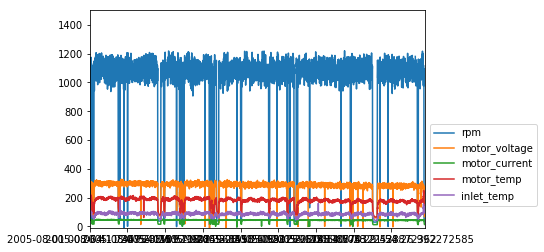

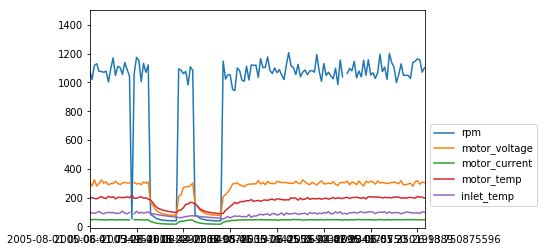

In [2]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp")

rms = load_rms('data/train/unit0000_rms.csv')

# functions to filter out outliers from dataset
def filter(dataframe):
    low = .01
    high = .99
    quant_df = dataframe.quantile([low, high])
    fil_dataframe = dataframe.apply(lambda x: x[(x>quant_df.loc[low,x.name]) 
                                                & (x < quant_df.loc[high,x.name])], axis=0)
    return fil_dataframe

def filter2(datafarame):
    q = dataframe.quantile(0.99)
    rms_filtered = dataframe[dataframe < q]
    return rms_filtered

rms_filtered=filter(rms)

rms_filtered.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500)).legend(bbox_to_anchor=(1.0, 0.5))
rms_filtered.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500)).legend(bbox_to_anchor=(1.0, 0.5))

display(rms_filtered.describe())

By being filtered, the dataset yields a much cleaner view. The statistical analysis result of the data shown in the table makes more sense as well.

Next we can explore the correlationship between those data. Although multiple correlation methods are available, considering the potential linearity relationship between voltage and current pair, as well as the moter temp and inlet temp pair, we choose the pearson method.

In [3]:
# correlation test of the attributes by pearson
rms_filtered.corr(method ='pearson') 

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
rpm,1.000000,0.901358,0.815531,0.547175,0.384274
motor_voltage,0.901358,1.000000,0.971148,0.818355,0.631354
motor_current,0.815531,0.971148,1.000000,0.899623,0.709096
motor_temp,0.547175,0.818355,0.899623,1.000000,0.888523
inlet_temp,0.384274,0.631354,0.709096,0.888523,1.000000


As shown above, indeed there is a strong relationship between voltage and current. Meanwhile, we can see the rpm is highly correlated with motor_voltage and motor_current. This is easily interpretable as higher voltage and current will drive machine to higher working rpm. Meanwhile, we can not overlook the fact that the rpm drops quite more significantly comparing to voltage/current. This indicates there exists a threshold of voltage/current. In other words, the machine will begin working above this threshold and stop working otherwise. So we cannot simply use voltage/current data to represent rpm. Additionally, motor_temp and inlet_temp are highly correlated as expected. But their correlation with rpm is not big. This may indicates a very efficient cooling system exists. Those information can be useful for potential PCA data processing. But for now, we just leave the idea here as there are not too many attributes in total.  

Another analysis that we can perform to the dataset is the Survival Analysis with a Kaplan-meier curve on the rms dataset which is sampled more consistantly timewise.  

Text(0.5, 0, 'Monitor cycles')

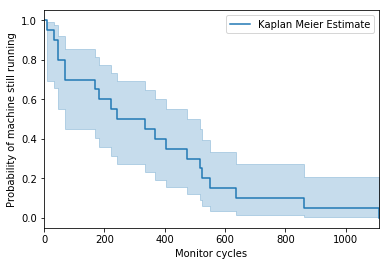

In [4]:
import glob
import pandas as pd
from lifelines import KaplanMeierFitter
%matplotlib inline 

survival_days = []
for file_name in glob.glob('data/train/*_rms.csv'):
    dataframe = pd.read_csv(file_name)
    dataframe['timestamp'] = pd.to_datetime(dataframe.timestamp)
    surv_days = (dataframe.timestamp.max()-dataframe.timestamp.min()).days
    survival_days.append(surv_days)
    
event_observed = [1]*20
kmf = KaplanMeierFitter() 

kmf.fit(survival_days, event_observed,label='Kaplan Meier Estimate')
kmf.plot()
plt.ylabel("Probability of machine still running")
plt.xlabel("Monitor cycles")

The survival analysis yields a more or less linear relationship between the monitor cycle and the probability that a machine is running properly. This can give us a general idea about the average running time of a machine in terms of monitor cycles.

We want to interpret whether a machine needs a maintenance before it actually fails based on the training data. Here I choose again the rms dataset over the alarms dataset as a time-evenly sampled data will in general yield better prediction accuracy. But, to clarify, alarms dataset can still be useful as the pattern of alarms, e.g. frequence pattern, can still convey information of machine failure. For the sake of time, I just implemented the analysis based on rms dataset. 

Next we need to figure out the prediction method. Several methods are available for such classfication problem based on time series data, such as HMM and RNN. Here I choose RNN over HMM. The reasons are as following: first, the output is of HMM is essentially a linear transformation of the initial HMM state, which make HMM model "shallow". In contrast, RNN has the hidden state as a form of non-linear regression of all past inputs. This enables RNN to be a much more complex model with long term dependency; second, HMM needs a strong assumption of the data. With current information, it is hard to generate a valid assumption for HMM. 

Here I implemented LSTM neural network to see whether we can successfully predict the remaining life time of a machine. I split the code into three main parts:

a, Preprocessing of the data
    this includes teasing out outliers from the data and filling the gaps (NaNs) with functions like dataframe.interpolate() or dataframe.fillna(). Data MinMax normalizaton.

b, Generate data sequence for model training
    this can be customized for the duration that one wants to predict on
    
c, Model training and testing data prediction

In [5]:
import os
import glob
import re
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


# function for sort the csv file in numerical order when entering for loop
# to ensure the ID value is correctly assigned
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def filter(df):
    low = .01
    high = .99
    quant_df = df.quantile([low, high])
    fil_df = df.apply(lambda x: x[(x>=quant_df.loc[low,x.name]) 
                                                & (x <= quant_df.loc[high,x.name])], axis=0)
    return fil_df

##########################
## Data Preprocessing  ##
##########################

dfTrain_List = []
ID = 0

for train_file in sorted(glob.glob('data/train/*_rms.csv'), key=numericalSort):
    trainDf = pd.read_csv(train_file)
    trainDf.drop('timestamp', axis=1, inplace=True)
    trainDf = filter(trainDf)
    # fill NaN with first interpolate then fillna function
    trainDf = trainDf.interpolate()
    trainDf = trainDf.fillna(0)
    # assign id to each machine
    trainDf["id"] = ID
    ID += 1
    # numbering each monitor cycle
    trainDf["cycle"] = trainDf.index + 1
    # Tof: Time to failure
    trainDf["TTF"] = trainDf["cycle"].values[::-1]
    # add all training data to a list
    dfTrain_List.append(trainDf)
    

# combine all training data together    
concatTrain = pd.concat(dfTrain_List, axis=0)

# generate label columns for training data
# is a machine going to fail within x cycles?
# every day monitors will run ~150 cycles
# we can set x to any numbers, but I set it as 150 to see whether a machine will fail within a day

x = 150
concatTrain['label'] = np.where(concatTrain['TTF'] <= x, 1, 0 )

# Training data MinMax normalization 
concatTrain['cycle_norm'] = concatTrain['cycle']

# df.columns.difference returns as output a new list of columns 
# from the existing columns excluding the ones given as arguments.
# separate out the cols that need to be normalized as cols_normalized
cols_normalize = concatTrain.columns.difference(['id','cycle','TTF','label'])

min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(concatTrain[cols_normalize]), 
                             columns=cols_normalize, 
                             index=concatTrain.index)

# combine normalized data columns with non-normalized colums
join_df = pd.concat([concatTrain[concatTrain.columns.difference(cols_normalize)], norm_train_df], axis=1)
concatTrain = join_df.reindex(columns = concatTrain.columns)


# same preprocessing to test data
dfTest_List = []

for test_file in sorted(glob.glob('data/test/*_rms.csv'), key=numericalSort):
    testDf = pd.read_csv(test_file)
    testDf.drop('timestamp', axis=1, inplace=True)
    testDf = filter(testDf)
    # fill NaN with first interpolate then fillna function
    testDf = testDf.interpolate()
    testDf = testDf.fillna(0)
    testDf["id"] = ID
    ID += 1
    testDf["cycle"] = testDf.index + 1
    testDf["TTF"] = testDf["cycle"].values[::-1]

    dfTest_List.append(testDf)
    
concatTest = pd.concat(dfTest_List, axis=0)

concatTest['cycle_norm'] = concatTest['cycle']

norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(concatTest[cols_normalize]), 
                             columns=cols_normalize, 
                             index=concatTest.index)

join_df = pd.concat([concatTest[concatTest.columns.difference(cols_normalize)], norm_test_df], axis=1)

concatTest = join_df.reindex(columns = concatTest.columns)


Using TensorFlow backend.


In [6]:
##############################
##  Generate data sequence  ##
##############################

sequence_length = 150

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), 
                           range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
sequence_cols = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 
                 'inlet_temp', 'cycle_norm']

seq_gen = (list(gen_sequence(concatTrain[concatTrain['id']==id], sequence_length, sequence_cols)) 
           for id in concatTrain['id'].unique())

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

label_gen = [gen_labels(concatTrain[concatTrain['id']==id], sequence_length, ['label']) 
             for id in concatTrain['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)


In [8]:
##################################
##  Model training and testing  ##
##################################

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

# model.add(Dense(units=nb_out, activation='sigmoid'))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("LSTM Model Summary:")
print(model.summary())

model.fit(seq_array, label_array, epochs=1, batch_size=2000, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, 
                                                     verbose=0, mode='min')])

scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

seq_array_test_last = [concatTest[concatTest['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in concatTest['id'].unique() 
                       if len(concatTest[concatTest['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

print(seq_array_test_last.shape)

# make predictions and compute confusion matrix
y_pred_test = model.predict_classes(seq_array_test_last)

print("PREDIECTED TEST LABELs:")
print(y_pred_test)

LSTM Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150, 100)          42800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2         
Total params: 73,053
Trainable params: 73,053
Non-trainable params: 0
____________________________________________________

In the above RNN model, we set the length of data sequence as 150 cycles, which roughly equals to one day. Again, we can set this duration as any cycle number depends on our needs. Then training data is used to generate a sequence of data contains a series of 150 cycles with the label of whether machine fails within next day. Then training data is separated to training and validating sets with ration of 0.95 to 0.05. Finally, the last 150 cycles of testing data was tested out to predict whether that test machine will fail in the next day.

Model training with all the training data is a very time-consuming process (~30 mins per epoch). I tried to run my code on GCP console but got little improvement in terms of time with only 1 GPU. So I decided to run only 1 epoch for the model training process which generated the the result above.   

Again, due to this being a very time-consuming, I was not able to fine-tune the LSTM structure and parameters. The model that I implemented here is based on the PredictiveMaintenance model of Microsoft Azure project. But I hope the general idea makes sense to you.

Some additional thoughs on this project:

a, To fill the gaps in the dataset, I used the interpolating method, which is basically a linear method to repair data based on the values between two inliers. This simple method would work if the two boundary inliers are close and the overall pattern of data values are linear. However, withou verifying this assumption, such interpolating method could confuse the LSTM network and thus yield inaccurate classification result. One of the better methods would be to train a model based on all the inlier data and predict the missing values to better repair the missing information. Another method would be to use the correlation between different attributes to predict the missing value. Moreover, if the outliers in some training data are too large portion, we can even drop that trainig file to avoid confusion. 

b, From the data correlation test, we can see that some data attributes are closely related to each other. This could indicate a potential PCA analysis to reduce the model complexity and computational cost. Due to the few attributes in this project, I did not implement such method. 

c, As this project is a classification problem, there is no need to convert the predict value back to the true value range from the normalized data value. However, such convertion is needed if this problem is to predict a value of an attributes instead of the label of the sample. 

In summary, I thank again Tagup for giving this opportunity to work on this fun challenge. I used the knowlege that I learned from classes. I also refreshed myself with many new methods while trying to figure out some of the data analysis. Unfortunately, I was not able to deliever a fine-tuned model as I am also busy working on some of my finals of the school but I really enjoyed it a lot!

Thanks very much for your time reading this. 